In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from pathlib import Path
import os
import numpy as np
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [2]:
## Read data

In [3]:
df = pd.read_csv('Dataset/bbc_text.csv', encoding = "ISO-8859-1")

In [4]:
## Let's view the data table

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
## Let's check number of rows.
print("No of rows - ", len(df))

No of rows -  2225


In [7]:
## We'll remove any row if either category or text is null
df = df[df['category'].notnull()]
df = df[df['text'].notnull()]
print("No of rows - ", len(df))

No of rows -  2225


Let's check the no of texts in each category

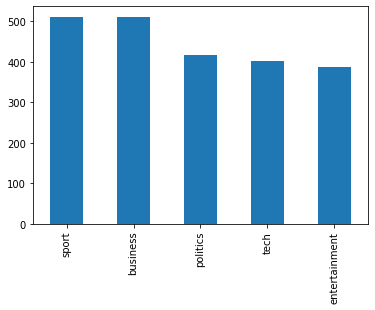

In [8]:
df['category'].value_counts().plot(kind = 'bar')

It's pretty evenly distributed.

#### Let's check no of words in articles

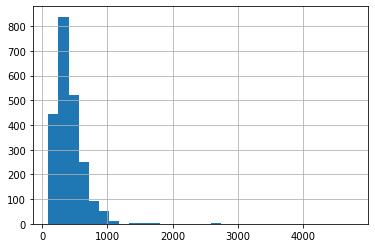

In [9]:
df['word_counts'] = df['text'].apply(lambda x: len(x.split(' ')))
df['word_counts'].hist(bins = 30)

Mostly, the number of words in articles is less than 1000.

#### Let's check some of the articles

In [10]:
df['text'][0][:2000]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

It's already clean. No further cleaning action is needed.

### Let's check some of the most used words.

In [14]:
words = [word for a in df['text'].apply(lambda x: x.split(' ')) for word in a]

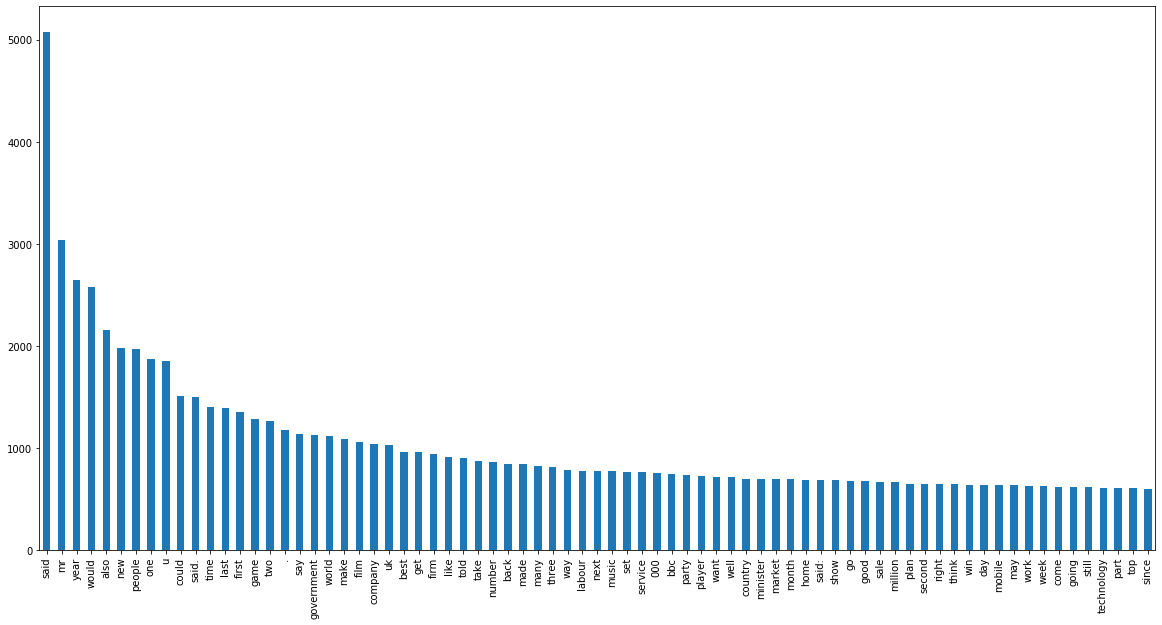

In [15]:
pd.Series(words).value_counts()[:75].plot(kind = 'bar', figsize = (20, 10))

We can see a few words have way higher counts. I think we can remove any word with count of more than 1500.

In [16]:
word_counts = Counter(words)
extra_words = set([word for word in words if word_counts[word]>1500])
def remove_extra_words(text):
    text = ' '.join(word for word in text.split() if not word in extra_words)
    return text
df['text'] = df['text'].apply(remove_extra_words)

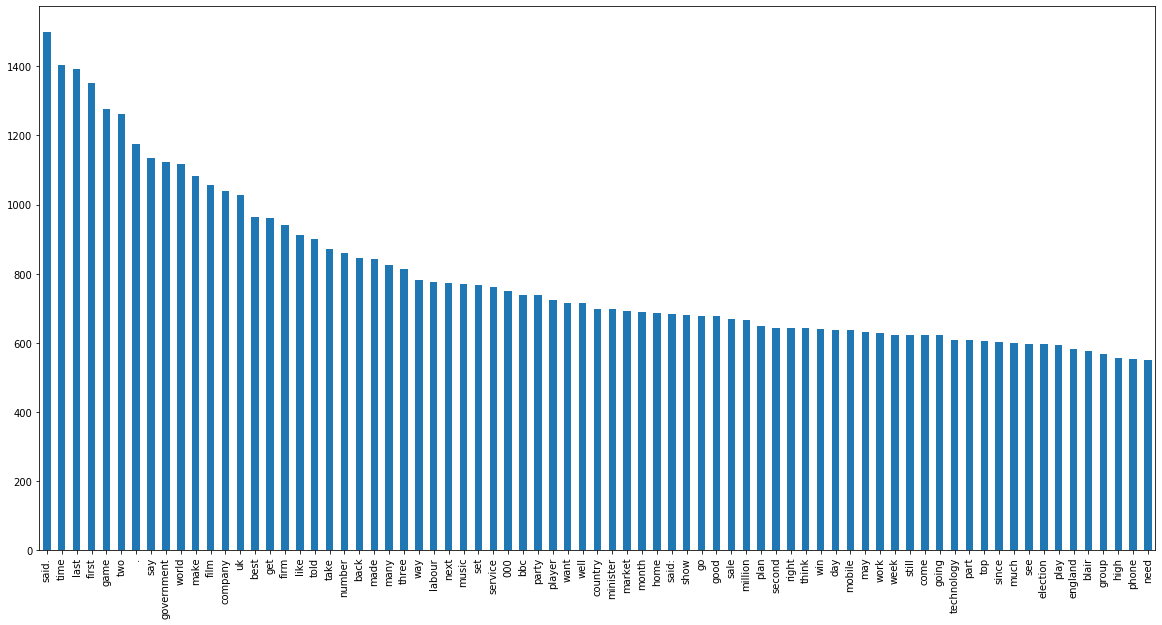

In [17]:
words = [word for a in df['text'].apply(lambda x: x.split(' ')) for word in a]
pd.Series(words).value_counts()[:75].plot(kind = 'bar', figsize = (20, 10))

It's okey now.

## Let's perform Text Classification

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

In [19]:
X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [41]:
max_features = 1000

## Naive Bayes Classifier for Multinomial Models

In [42]:
from sklearn.naive_bayes import MultinomialNB

In [43]:
nb = Pipeline([('tfidf', TfidfVectorizer(min_df = 5, max_features = max_features, smooth_idf=True, use_idf=True)),
               ('clf', MultinomialNB()),
              ])

In [44]:
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
my_tags = y_train.unique().tolist().sort()
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.9483146067415731
               precision    recall  f1-score   support

     business       0.91      0.92      0.92       101
entertainment       0.97      0.96      0.97        81
     politics       0.93      0.94      0.93        83
        sport       0.96      0.98      0.97        98
         tech       0.97      0.94      0.96        82

  avg / total       0.95      0.95      0.95       445



C:\Users\Goldi\AppData\Roaming\Python\Python36\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


## Linear Support Vector Machine

In [45]:
from sklearn.linear_model import SGDClassifier

In [46]:
sgd = Pipeline([('tfidf', TfidfVectorizer(min_df = 7, max_features = 5000, smooth_idf=True, use_idf=True)),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [47]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
my_tags = y_train.unique().tolist().sort()
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

C:\Users\Goldi\AppData\Roaming\Python\Python36\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


accuracy 0.9662921348314607
               precision    recall  f1-score   support

     business       0.97      0.90      0.93       101
entertainment       0.98      0.99      0.98        81
     politics       0.94      0.98      0.96        83
        sport       0.97      1.00      0.98        98
         tech       0.98      0.98      0.98        82

  avg / total       0.97      0.97      0.97       445



## Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e7, tol = 1e-4, max_iter = 1000)),
               ])

In [50]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\Goldi\AppData\Roaming\Python\Python36\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [51]:
my_tags = y_train.unique().tolist().sort()
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9775280898876404
               precision    recall  f1-score   support

     business       0.98      0.93      0.95       101
entertainment       1.00      1.00      1.00        81
     politics       0.94      0.98      0.96        83
        sport       0.98      1.00      0.99        98
         tech       0.99      0.99      0.99        82

  avg / total       0.98      0.98      0.98       445



We can see improvement. But, it's still not enough. Let's see if we can get better.

## XGBoost

In [52]:
from xgboost import XGBClassifier

In [53]:
xgb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(max_depth=4, n_estimators=300, learning_rate=0.1)),
               ])

In [54]:
xgb.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\Goldi\AppData\Roaming\Python\Python36\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\Goldi\AppData\Roaming\Python\Python36\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [55]:
my_tags = y_train.unique().tolist().sort()
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9775280898876404
               precision    recall  f1-score   support

     business       0.98      0.93      0.95       101
entertainment       1.00      1.00      1.00        81
     politics       0.94      0.98      0.96        83
        sport       0.98      1.00      0.99        98
         tech       0.99      0.99      0.99        82

  avg / total       0.98      0.98      0.98       445



## Word2vec and Logistic Regression

In [20]:
from gensim.models import Word2Vec, KeyedVectors
import gensim
from sklearn.linear_model import LogisticRegression

In [21]:
w2v_corpus = os.path.join(Path.home(), 'Projects\\Accessories\\nlp\\GoogleNews-vectors-negative300.bin.gz')
wv = KeyedVectors.load_word2vec_format(w2v_corpus, binary=True)
wv.init_sims(replace=True)

In [22]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

In [23]:
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [24]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [25]:
train, test = train_test_split(df[['category', 'text']], test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

C:\Anaconda3\envs\medium\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


In [28]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['category'])
y_pred = logreg.predict(X_test_word_average)

my_tags = train['category'].unique().tolist().sort()
print('accuracy %s' % accuracy_score(y_pred, test.category))
print(classification_report(test.category, y_pred,target_names=my_tags))

accuracy 0.9670658682634731
               precision    recall  f1-score   support

     business       0.96      0.93      0.94       164
entertainment       0.98      0.97      0.98       113
     politics       0.92      0.96      0.94       113
        sport       1.00      0.99      1.00       146
         tech       0.96      0.98      0.97       132

  avg / total       0.97      0.97      0.97       668



## Doc2vec and Logistic Regression

In [29]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument

In [30]:
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.category, random_state=0, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [33]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████████| 2225/2225 [00:00<00:00, 557553.26it/s]


In [34]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [35]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

my_tags = train['category'].unique().tolist().sort()
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9775280898876404
               precision    recall  f1-score   support

     business       0.99      0.99      0.99        97
entertainment       0.95      0.99      0.97        81
     politics       0.97      0.93      0.95        75
        sport       0.98      0.99      0.99       112
         tech       0.99      0.97      0.98        80

  avg / total       0.98      0.98      0.98       445



## Bag of Words (BOW) with Keras

In [6]:
import itertools

import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [16]:
train_text, test_text, train_category, test_category = train_test_split(df.text, df.category, random_state=0, test_size=0.3)

In [31]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_text) # only fit on train

In [32]:
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [10]:
encoder = LabelEncoder()
encoder.fit(train_category)
y_train = encoder.transform(train_category)
y_test = encoder.transform(test_category)

In [11]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [35]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1557, 1000)
x_test shape: (668, 1000)
y_train shape: (1557, 5)
y_test shape: (668, 5)


In [36]:
batch_size = 32
epochs = 100

In [37]:
# Build the model
model = Sequential()

model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1401 samples, validate on 156 samples
Epoch 1/100
1401/1401 [==============================] - 1s 610us/step - loss: 0.6576 - acc: 0.7666 - val_loss: 0.1314 - val_acc: 0.9551
Epoch 2/100
1401/1401 [==============================] - 0s 213us/step - loss: 0.0894 - acc: 0.9743 - val_loss: 0.1467 - val_acc: 0.9551
Epoch 3/100
1401/1401 [==============================] - 0s 202us/step - loss: 0.0173 - acc: 0.9957 - val_loss: 0.1243 - val_acc: 0.9615
Epoch 4/100
1401/1401 [==============================] - 0s 205us/step - loss: 0.0102 - acc: 0.9979 - val_loss: 0.1009 - val_acc: 0.9551
Epoch 5/100
1401/1401 [==============================] - 0s 207us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.1019 - val_acc: 0.9744
Epoch 6/100
1401/1401 [==============================] - 0s 201us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1050 - val_acc: 0.9679
Epoch 7/100
1401/1401 [==============================] - 0s 202us/step - loss: 8.7578e-04 - acc: 1.0000 - val_loss: 0.1052 - val_ac

In [39]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

668/668 [==============================] - 0s 69us/step
Test loss: 0.13209199021128937
Test accuracy: 0.9670658671927309


All the models worked pretty good on this dataset. The highest accuracy I got is 98 with Logistic Regression and XGBoost. This will vary for different types of data. I may be able to push the accuracy further with some hyperparameter training.